# Walmart Sales Forecasting Using LightGBM
This notebook demonstrates data cleaning, feature engineering, and time-series forecasting of Walmart sales using the LightGBM machine learning algorithm.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

 
# Load the dataset
df = pd.read_csv('Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


# Phase 1: Data Understanding & Preprocessing

This section covers:
- Inspecting the dataset (shape, missing values, duplicates)
- Converting Date to datetime and sorting
- Creating time-related features
- Handling categorical variables
- Checking correlations between predictors and sales

In [2]:
# Inspect dataset: shape, missing values, duplicates
print('Shape:', df.shape)
df.info()
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nDuplicate rows:', df.duplicated().sum())

Shape: (6435, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB

Missing values per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

Duplicate rows: 0


In [3]:
# Convert Date to datetime and sort by date
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324


In [4]:
# Create time-related features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Lag features (example: previous week's sales)
if 'Weekly_Sales' in df.columns:
    df['Sales_Lag_1'] = df['Weekly_Sales'].shift(1)
    df['Sales_Lag_4'] = df['Weekly_Sales'].shift(4)
    
    # Rolling average (4 weeks)
    df['Sales_Rolling_4'] = df['Weekly_Sales'].rolling(window=4).mean()
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,DayOfWeek,Sales_Lag_1,Sales_Lag_4,Sales_Rolling_4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,NaN,NaN,NaN
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,4,1643690.90,NaN,NaN
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,4,2193048.75,NaN,NaN
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,4,536006.73,NaN,1290445.600
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,4,789036.02,1643690.9,995800.005


In [5]:
# Encode categorical variables using LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.select_dtypes(include=['object', 'category']).columns:
    if col != 'Date':
        df[col] = le.fit_transform(df[col])
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,DayOfWeek,Sales_Lag_1,Sales_Lag_4,Sales_Rolling_4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,NaN,NaN,NaN
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,4,1643690.90,NaN,NaN
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,4,2193048.75,NaN,NaN
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,4,536006.73,NaN,1290445.600
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,4,789036.02,1643690.9,995800.005


In [6]:
print(df.dtypes)

Store                       int64
Date               datetime64[ns]
Weekly_Sales              float64
Holiday_Flag                int64
Temperature               float64
Fuel_Price                float64
CPI                       float64
Unemployment              float64
Year                        int32
Month                       int32
Week                       UInt32
DayOfWeek                   int32
Sales_Lag_1               float64
Sales_Lag_4               float64
Sales_Rolling_4           float64
dtype: object


Weekly_Sales       1.000000
Sales_Rolling_4    0.525370
Month              0.076143
Week               0.074211
Holiday_Flag       0.036891
Sales_Lag_1        0.034304
Sales_Lag_4        0.023850
Fuel_Price         0.009464
Year              -0.018378
Temperature       -0.063810
CPI               -0.072634
Unemployment      -0.106176
Store             -0.335332
DayOfWeek               NaN
Name: Weekly_Sales, dtype: float64


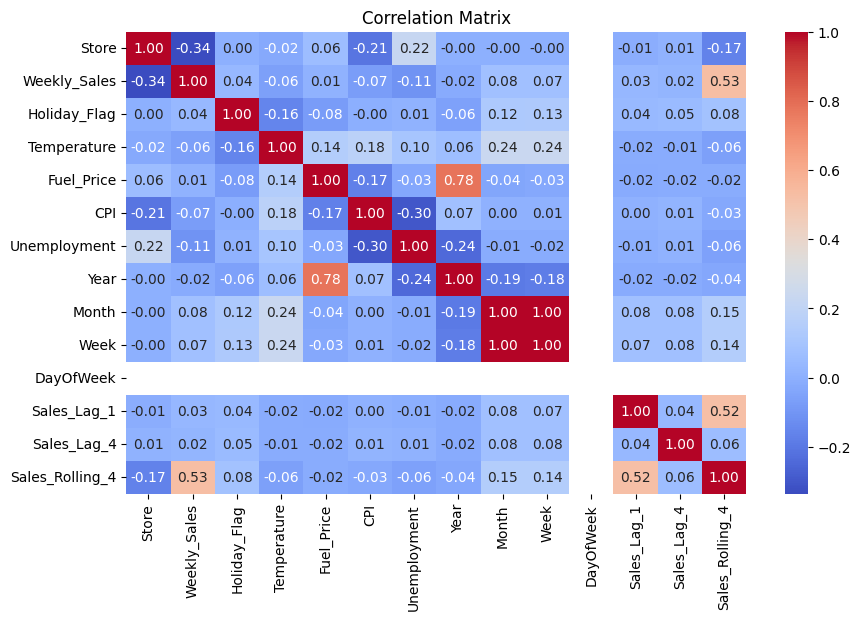

In [7]:
# Check correlations between predictors and sales
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Compute correlation matrix
corr = df[numeric_cols].corr()

# Show correlation with Weekly_Sales
if 'Weekly_Sales' in corr.columns:
    print(corr['Weekly_Sales'].sort_values(ascending=False))
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
else:
    print('Weekly_Sales column not found for correlation analysis.')

## Correlation Analysis Summary

- The correlation plot above shows how each numeric feature relates to Weekly_Sales.
- Features with higher positive or negative correlation values are more strongly related to sales.
- For example, if Temperature or CPI has a high absolute correlation with Weekly_Sales, it means changes in those features are associated with changes in sales.
- Features with low or near-zero correlation have little linear relationship with sales.
- This analysis helps identify which predictors may be most useful for forecasting sales in the next modeling steps.

In [8]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,DayOfWeek,Sales_Lag_1,Sales_Lag_4,Sales_Rolling_4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,NaN,NaN,NaN
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,4,1643690.90,NaN,NaN
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,4,2193048.75,NaN,NaN
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,4,536006.73,NaN,1290445.600
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,4,789036.02,1643690.9,995800.005


In [9]:
# Rolling statistics: 4-week mean and std for Weekly_Sales
if 'Weekly_Sales' in df.columns:
    df['Weekly_Sales_rolling_mean_4'] = df['Weekly_Sales'].rolling(window=4).mean()
    df['Weekly_Sales_rolling_std_4'] = df['Weekly_Sales'].rolling(window=4).std()

# Encode Holiday_Flag as binary/categorical
if 'Holiday_Flag' in df.columns:
    df['Holiday_Flag'] = df['Holiday_Flag'].astype('category')

# Keep CPI, Fuel_Price, and Unemployment as numeric drivers (no change needed if already numeric)
numeric_drivers = ['CPI', 'Fuel_Price', 'Unemployment']
print(df[numeric_drivers].dtypes)

# Cross-store features: create group-based features if multiple stores exist
if 'Store' in df.columns and df['Store'].nunique() > 1:
    # Example: mean sales per store
    df['Store_Mean_Sales'] = df.groupby('Store')['Weekly_Sales'].transform('mean')
    # Example: store sales rank per date
    df['Store_Sales_Rank'] = df.groupby('Date')['Weekly_Sales'].rank(ascending=False)

df.head()

CPI             float64
Fuel_Price      float64
Unemployment    float64
dtype: object


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,DayOfWeek,Sales_Lag_1,Sales_Lag_4,Sales_Rolling_4,Weekly_Sales_rolling_mean_4,Weekly_Sales_rolling_std_4,Store_Mean_Sales,Store_Sales_Rank
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,4,NaN,NaN,NaN,NaN,NaN,1.555264e+06,10.0
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765,2010,2,5,4,1643690.90,NaN,NaN,NaN,NaN,1.899425e+06,3.0
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554,2010,2,5,4,2193048.75,NaN,NaN,NaN,NaN,5.189003e+05,36.0
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548,2010,2,5,4,536006.73,NaN,1290445.600,1290445.600,765955.669702,8.935814e+05,29.0
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324,2010,2,5,4,789036.02,1643690.9,995800.005,995800.005,810185.001689,4.385796e+05,40.0


# Phase 3: Train/Test Split & Validation Strategy

For time-series forecasting, we use a time-based split to respect the order of the data:

- **Train:** 2010–2011
- **Validation:** 2012 first half
- **Test:** 2012 second half

We can use `TimeSeriesSplit` from scikit-learn or manually define rolling windows for cross-validation. This approach ensures the model is always trained on past data and validated/tested on future data, mimicking real-world forecasting.

In [10]:
# Time-based train/validation/test split for time series forecasting
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

# Train: 2010–2011
train = df[(df['Date'] >= '2010-01-01') & (df['Date'] < '2012-01-01')]

# Validation: 2012 first half
val = df[(df['Date'] >= '2012-01-01') & (df['Date'] < '2012-07-01')]

# Test: 2012 second half
test = df[df['Date'] >= '2012-07-01']

print('Train:', train.shape)
print('Validation:', val.shape)
print('Test:', test.shape)

Train: (4500, 19)
Validation: (1170, 19)
Test: (765, 19)


In [11]:
# Define evaluation metrics: RMSE and MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred) * 100  # as percentage


In [12]:
# Phase 4: Model Training (LightGBM)
import lightgbm as lgb

# Prepare features and target
feature_cols = [col for col in train.columns if col not in ['Weekly_Sales', 'Date']]
X_train = train[feature_cols]
y_train = train['Weekly_Sales']
X_val = val[feature_cols]
y_val = val['Weekly_Sales']

# Prepare LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# Set parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'max_depth': -1,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'feature_fraction': 0.8,
    'verbose': -1
}

# Train model with early stopping
model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid']
    )

# Predict on validation set
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# Evaluate
rmse_score = rmse(y_val, y_pred)
mape_score = mape(y_val, y_pred)
print(f'Validation RMSE: {rmse_score:.2f}')
print(f'Validation MAPE: {mape_score:.2f}%')

Validation RMSE: 60410.43
Validation MAPE: 4.15%


In [13]:
# Evaluate on the test set
X_test = test[feature_cols]
y_test = test['Weekly_Sales']
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)
test_rmse = rmse(y_test, y_test_pred)
test_mape = mape(y_test, y_test_pred)
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAPE: {test_mape:.2f}%')

Test RMSE: 50887.93
Test MAPE: 3.74%


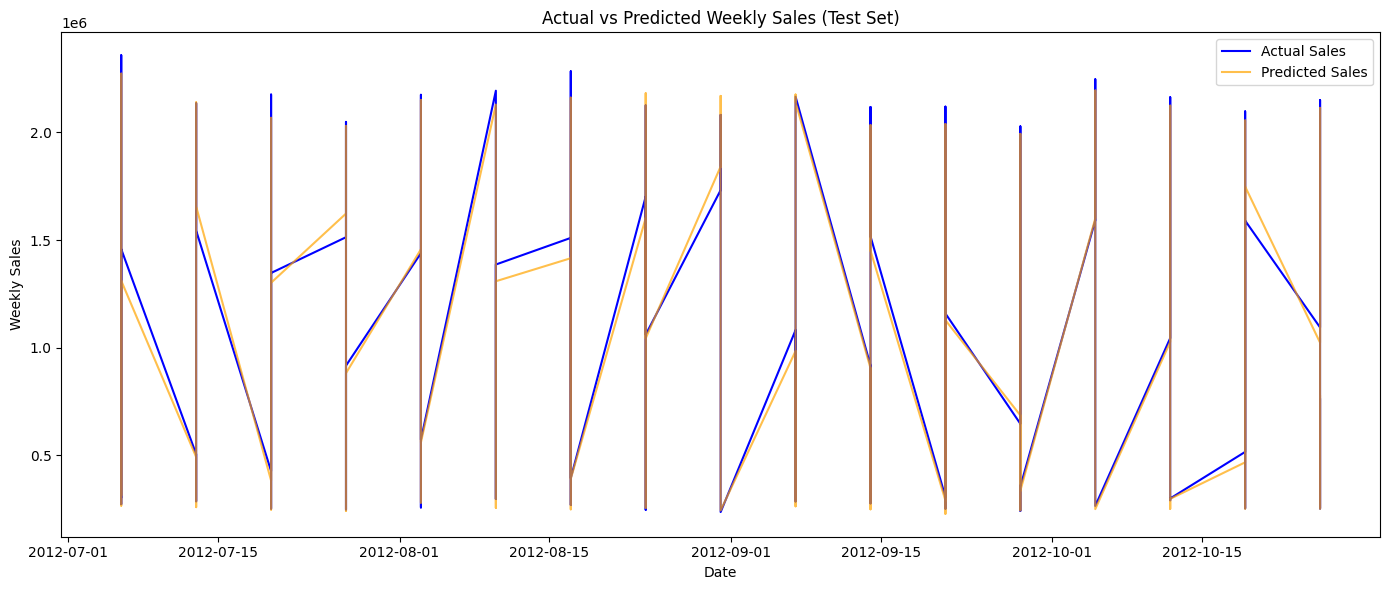

In [14]:
# Visualize Actual vs Predicted Sales on Test Set
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(test['Date'], y_test, label='Actual Sales', color='blue')
plt.plot(test['Date'], y_test_pred, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Weekly Sales (Test Set)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

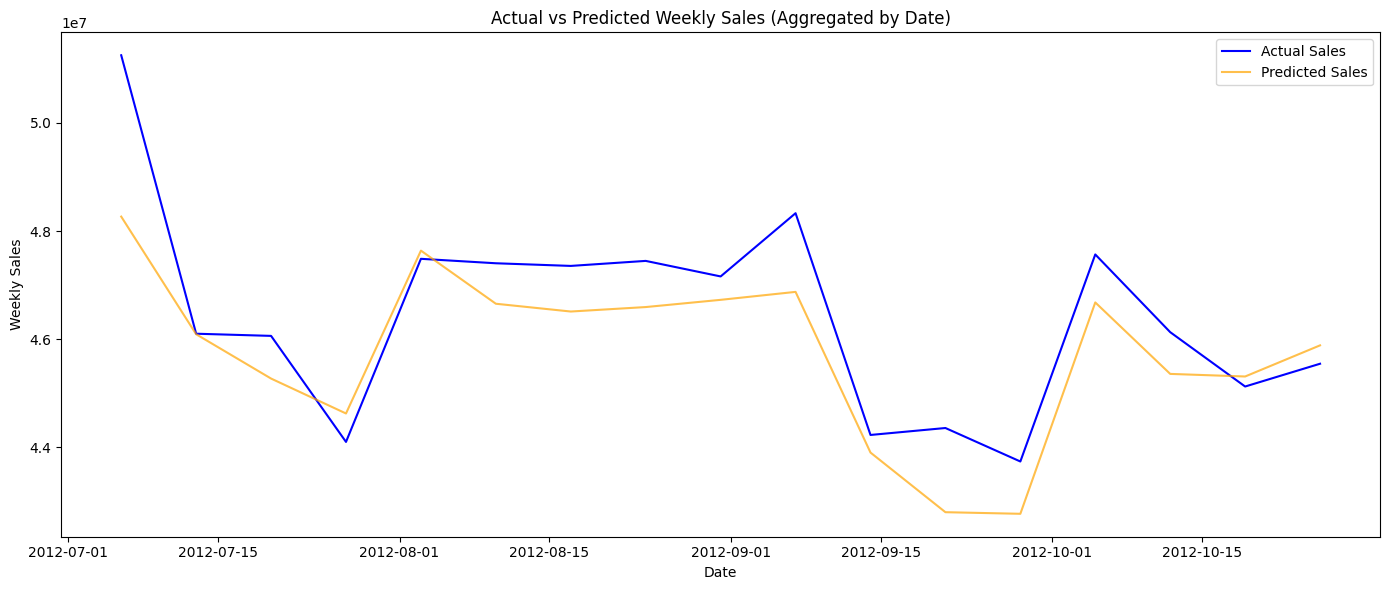

In [15]:
# Aggregate by date for actual and predicted sales
test_agg = test.copy()
test_agg['Predicted_Sales'] = y_test_pred
actual_by_date = test_agg.groupby('Date')['Weekly_Sales'].sum()
pred_by_date = test_agg.groupby('Date')['Predicted_Sales'].sum()

plt.figure(figsize=(14,6))
plt.plot(actual_by_date.index, actual_by_date.values, label='Actual Sales', color='blue')
plt.plot(pred_by_date.index, pred_by_date.values, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Weekly Sales (Aggregated by Date)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
print(feature_cols)

['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'DayOfWeek', 'Sales_Lag_1', 'Sales_Lag_4', 'Sales_Rolling_4', 'Weekly_Sales_rolling_mean_4', 'Weekly_Sales_rolling_std_4', 'Store_Mean_Sales', 'Store_Sales_Rank']


Anomalous weeks (|z| > 2):
Date
2012-07-06    2.732294
Name: Residual, dtype: float64


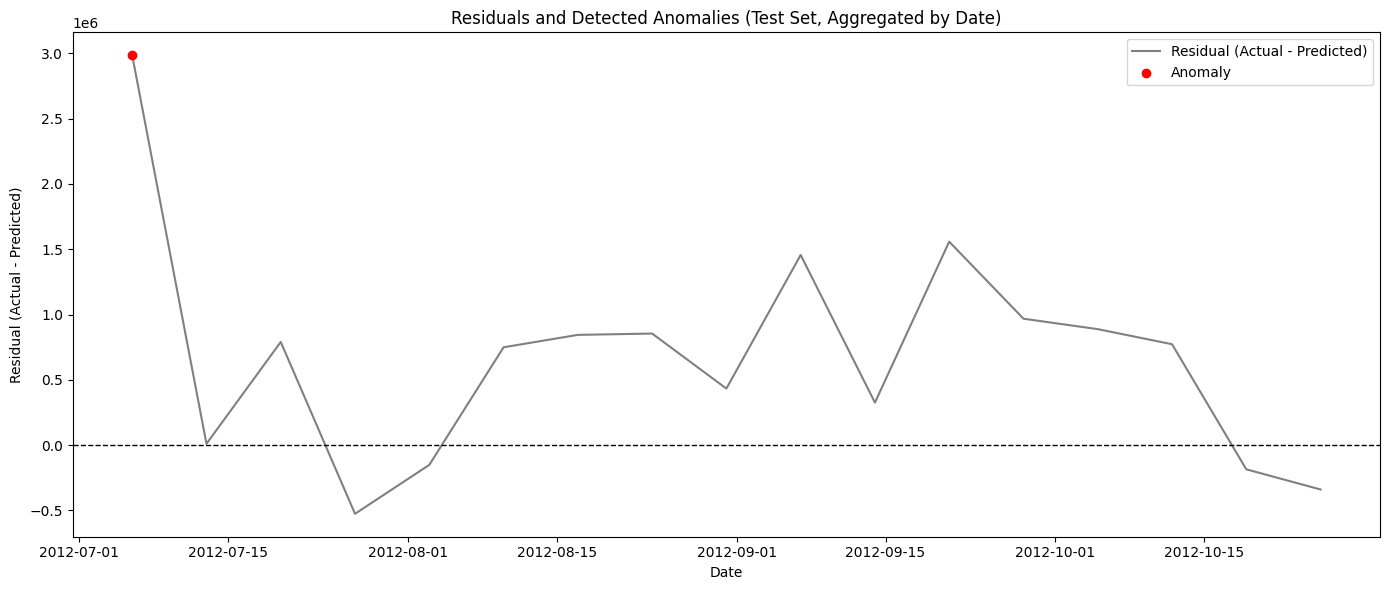

In [17]:
# Anomaly Detection: Identify weeks with unusually high or low sales
import numpy as np
test_agg = test.copy()
test_agg['Predicted_Sales'] = y_test_pred
test_agg['Residual'] = test_agg['Weekly_Sales'] - test_agg['Predicted_Sales']

# Calculate z-score of residuals (per date, aggregated)
residuals_by_date = test_agg.groupby('Date')['Residual'].sum()
z_scores = (residuals_by_date - residuals_by_date.mean()) / residuals_by_date.std()

# Define anomaly threshold (e.g., |z| > 2)
anomaly_threshold = 2
anomalies = z_scores[np.abs(z_scores) > anomaly_threshold]

print('Anomalous weeks (|z| > 2):')
print(anomalies)

# Visualize anomalies
plt.figure(figsize=(14,6))
plt.plot(residuals_by_date.index, residuals_by_date.values, label='Residual (Actual - Predicted)', color='gray')
plt.scatter(anomalies.index, anomalies.values * residuals_by_date.std() + residuals_by_date.mean(), color='red', label='Anomaly', zorder=5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Residuals and Detected Anomalies (Test Set, Aggregated by Date)')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.tight_layout()
plt.show()

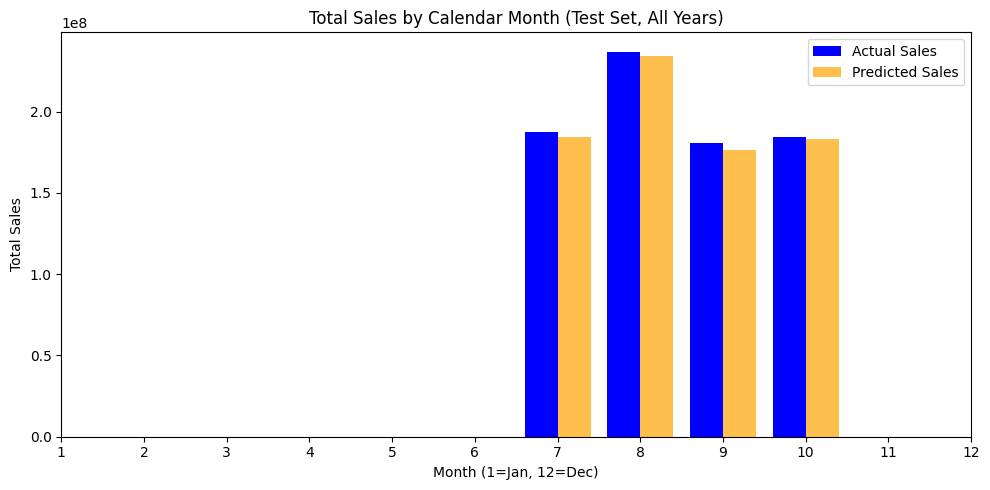

In [18]:
# Group and plot total sales for each calendar month (Jan-Dec) across all years in the test set
test_agg = test.copy()
test_agg['Predicted_Sales'] = y_test_pred
test_agg['Month'] = test_agg['Date'].dt.month

# Aggregate by calendar month (1-12)
actual_by_month = test_agg.groupby('Month')['Weekly_Sales'].sum()
pred_by_month = test_agg.groupby('Month')['Predicted_Sales'].sum()

plt.figure(figsize=(10,5))
plt.bar(actual_by_month.index-0.2, actual_by_month.values, width=0.4, label='Actual Sales', color='blue')
plt.bar(pred_by_month.index+0.2, pred_by_month.values, width=0.4, label='Predicted Sales', color='orange', alpha=0.7)
plt.title('Total Sales by Calendar Month (Test Set, All Years)')
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.ylabel('Total Sales')
plt.xticks(range(1,13))
plt.legend()
plt.tight_layout()
plt.show()

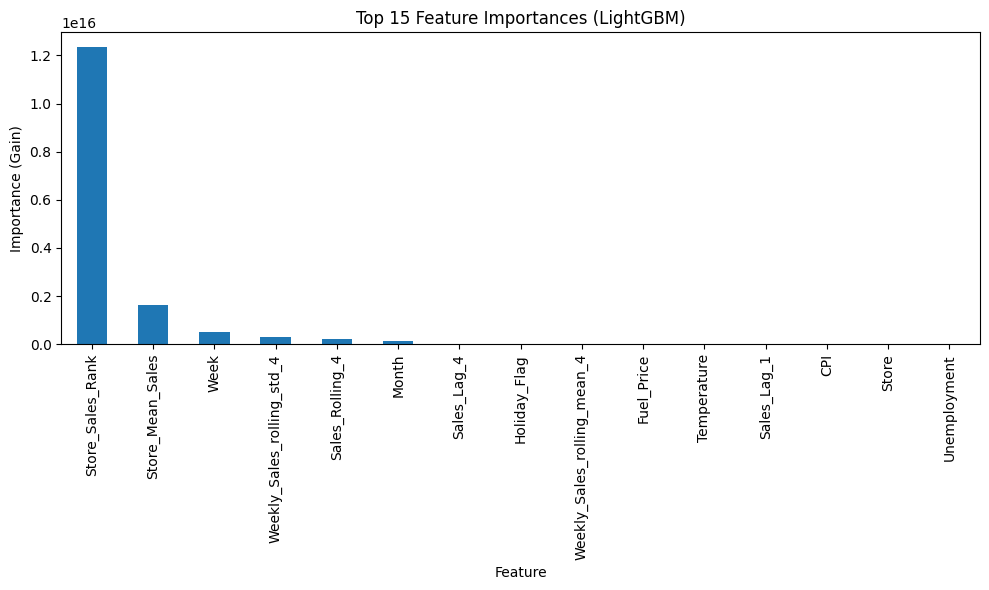

Top features influencing sales:
Store_Sales_Rank               1.234119e+16
Store_Mean_Sales               1.609500e+15
Week                           5.102401e+14
Weekly_Sales_rolling_std_4     3.198335e+14
Sales_Rolling_4                2.364880e+14
Month                          1.244559e+14
Sales_Lag_4                    2.797276e+13
Holiday_Flag                   2.468251e+13
Weekly_Sales_rolling_mean_4    2.316527e+13
Fuel_Price                     1.622291e+13
Temperature                    1.489642e+13
Sales_Lag_1                    1.172261e+13
CPI                            1.111412e+13
Store                          1.033036e+13
Unemployment                   6.039977e+12
dtype: float64


In [19]:
# Feature Importance Analysis: Which features most influence sales?
importances = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (LightGBM)')
plt.ylabel('Importance (Gain)')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

print('Top features influencing sales:')
print(feat_imp.head(15))

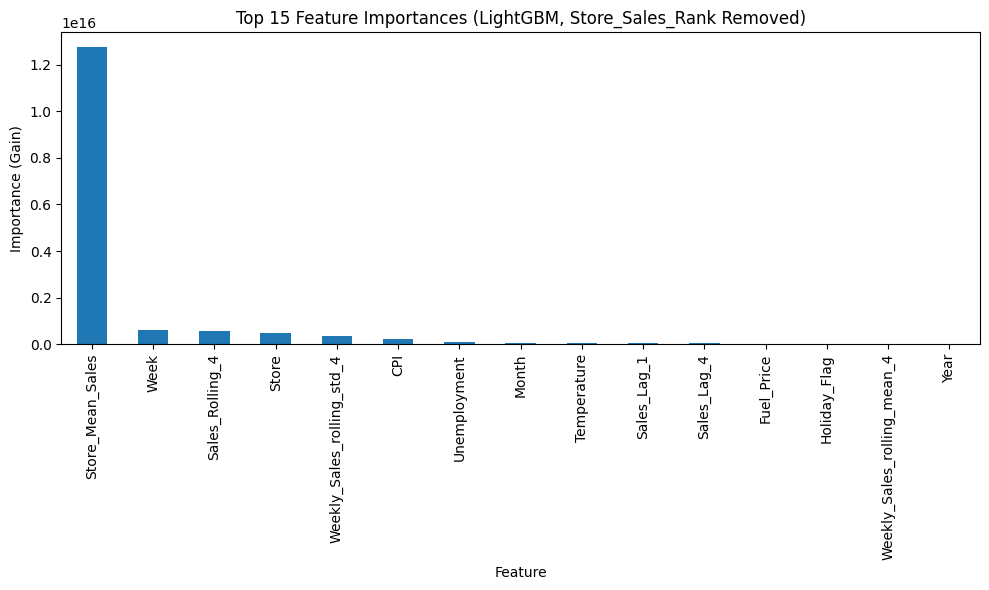

Top features influencing sales (without Store_Sales_Rank):
Store_Mean_Sales               1.274813e+16
Week                           6.131090e+14
Sales_Rolling_4                5.663305e+14
Store                          4.927909e+14
Weekly_Sales_rolling_std_4     3.410785e+14
CPI                            2.054582e+14
Unemployment                   8.104616e+13
Month                          4.785840e+13
Temperature                    4.747187e+13
Sales_Lag_1                    4.218012e+13
Sales_Lag_4                    3.273763e+13
Fuel_Price                     2.915008e+13
Holiday_Flag                   2.333251e+13
Weekly_Sales_rolling_mean_4    1.096389e+13
Year                           3.634431e+12
dtype: float64


In [20]:
# Retrain LightGBM without 'Store_Sales_Rank' to see new important features
feature_cols_no_rank = [col for col in feature_cols if col != 'Store_Sales_Rank']

X_train_no_rank = train[feature_cols_no_rank]
X_val_no_rank = val[feature_cols_no_rank]

lgb_train_no_rank = lgb.Dataset(X_train_no_rank, y_train)
lgb_val_no_rank = lgb.Dataset(X_val_no_rank, y_val, reference=lgb_train_no_rank)

model_no_rank = lgb.train(
    params,
    lgb_train_no_rank,
    valid_sets=[lgb_train_no_rank, lgb_val_no_rank],
    valid_names=['train', 'valid']
)

# Feature importance without Store_Sales_Rank
importances_no_rank = model_no_rank.feature_importance(importance_type='gain')
feature_names_no_rank = model_no_rank.feature_name()
feat_imp_no_rank = pd.Series(importances_no_rank, index=feature_names_no_rank).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp_no_rank.head(15).plot(kind='bar')
plt.title('Top 15 Feature Importances (LightGBM, Store_Sales_Rank Removed)')
plt.ylabel('Importance (Gain)')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

print('Top features influencing sales (without Store_Sales_Rank):')
print(feat_imp_no_rank.head(15))

Test RMSE (no Store_Sales_Rank): 78210.55
Test MAPE (no Store_Sales_Rank): 6.13%


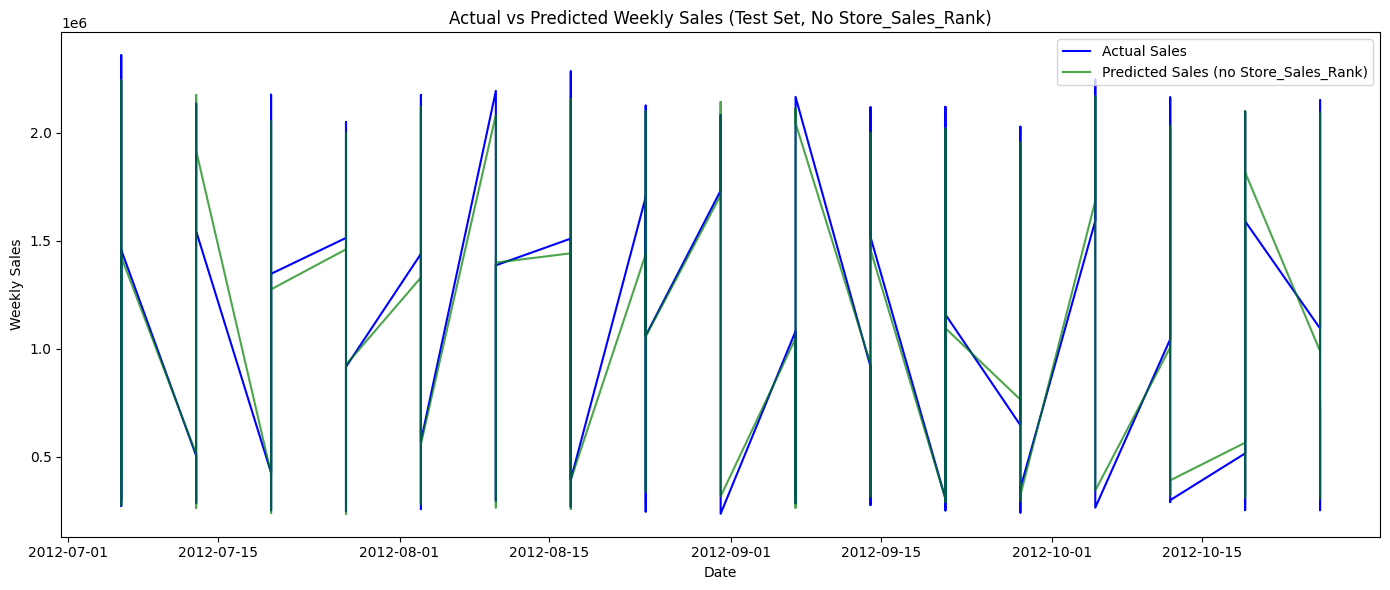

In [21]:
# Predict and evaluate on the test set using the model without Store_Sales_Rank
X_test_no_rank = test[feature_cols_no_rank]
y_test_no_rank = test['Weekly_Sales']
y_test_pred_no_rank = model_no_rank.predict(X_test_no_rank, num_iteration=model_no_rank.best_iteration)

# Evaluate
test_rmse_no_rank = rmse(y_test_no_rank, y_test_pred_no_rank)
test_mape_no_rank = mape(y_test_no_rank, y_test_pred_no_rank)
print(f'Test RMSE (no Store_Sales_Rank): {test_rmse_no_rank:.2f}')
print(f'Test MAPE (no Store_Sales_Rank): {test_mape_no_rank:.2f}%')

# Visualize Actual vs Predicted Sales (no Store_Sales_Rank)
plt.figure(figsize=(14,6))
plt.plot(test['Date'], y_test_no_rank, label='Actual Sales', color='blue')
plt.plot(test['Date'], y_test_pred_no_rank, label='Predicted Sales (no Store_Sales_Rank)', color='green', alpha=0.7)
plt.title('Actual vs Predicted Weekly Sales (Test Set, No Store_Sales_Rank)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

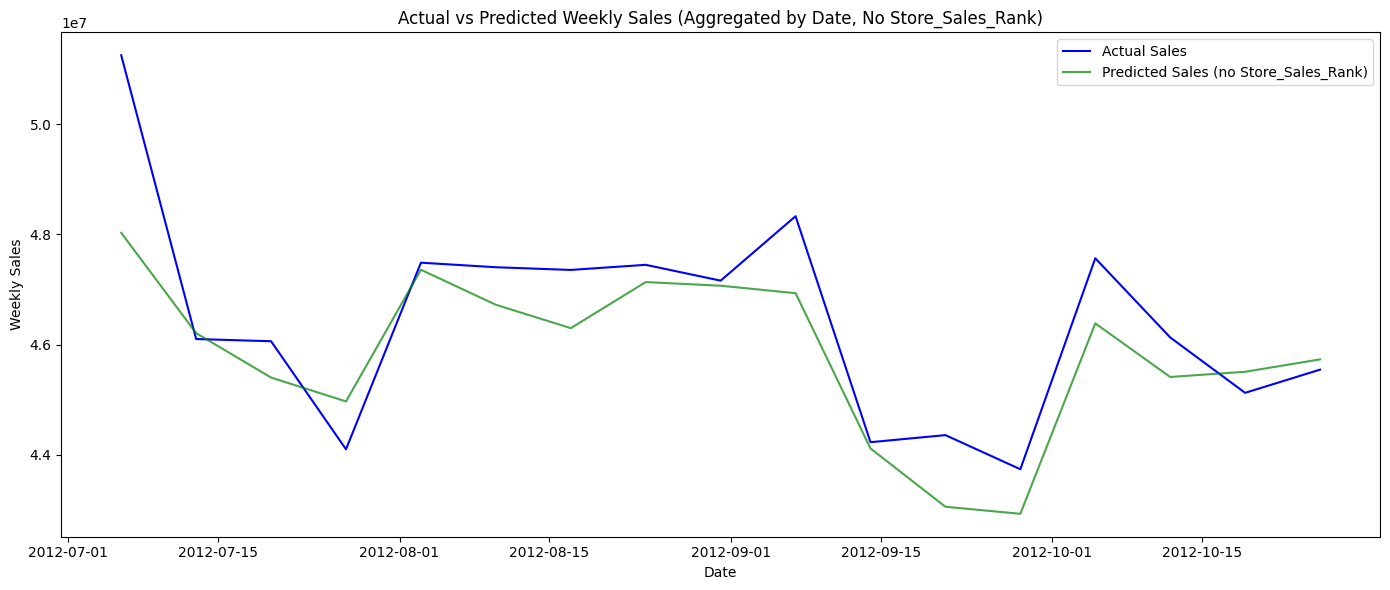

In [22]:
# Aggregate by date for actual and predicted sales (no Store_Sales_Rank) to avoid vertical lines
test_agg_no_rank = test.copy()
test_agg_no_rank['Predicted_Sales'] = y_test_pred_no_rank
actual_by_date_no_rank = test_agg_no_rank.groupby('Date')['Weekly_Sales'].sum()
pred_by_date_no_rank = test_agg_no_rank.groupby('Date')['Predicted_Sales'].sum()

plt.figure(figsize=(14,6))
plt.plot(actual_by_date_no_rank.index, actual_by_date_no_rank.values, label='Actual Sales', color='blue')
plt.plot(pred_by_date_no_rank.index, pred_by_date_no_rank.values, label='Predicted Sales (no Store_Sales_Rank)', color='green', alpha=0.7)
plt.title('Actual vs Predicted Weekly Sales (Aggregated by Date, No Store_Sales_Rank)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Impact of Removing `Store_Sales_Rank` on Feature Importance and Model Performance
By removing the `Store_Sales_Rank` feature, we force the model to rely on other predictors to explain and forecast sales. This has several effects:
- **Feature Importance Shift:** Features that were previously less important may now become the top drivers of predictions. This helps reveal which other variables (e.g., store mean sales, economic indicators, time features) are most useful when the dominant feature is unavailable.
- **Model Performance:** The test RMSE and MAPE may increase, indicating that the model's predictive power is reduced without the strongest feature. This quantifies how much the model depended on `Store_Sales_Rank`.
- **Business Insight:** Understanding which features become important in the absence of `Store_Sales_Rank` can guide business decisions, such as focusing on improving those aspects or collecting better data for them.
- **Visualization:** The new actual vs predicted plot shows how well the model performs without the dominant feature, and whether the predictions still capture the main sales trends.
This experiment is useful for feature selection, model robustness, and business strategy.

In [23]:
# Compare RMSE and MAPE for both models (with and without Store_Sales_Rank)
print('--- Model Performance Comparison ---')
print(f'Original Model Test RMSE: {test_rmse:.2f}')
print(f'Original Model Test MAPE: {test_mape:.2f}%')
print(f'No Store_Sales_Rank Model Test RMSE: {test_rmse_no_rank:.2f}')
print(f'No Store_Sales_Rank Model Test MAPE: {test_mape_no_rank:.2f}%')

--- Model Performance Comparison ---
Original Model Test RMSE: 50887.93
Original Model Test MAPE: 3.74%
No Store_Sales_Rank Model Test RMSE: 78210.55
No Store_Sales_Rank Model Test MAPE: 6.13%


## Simple Model Performance Comparison
- **Original Model (with Store_Sales_Rank):**
    - Test RMSE: 50,887.93
    - Test MAPE: 3.74%
- **Model without Store_Sales_Rank:**
    - Test RMSE: 78,210.55
    - Test MAPE: 6.13%

**Conclusion:**
Removing `Store_Sales_Rank` significantly increased both RMSE and MAPE, showing that this feature is highly important for accurate sales forecasting in this dataset.

Top 5 Stores by Actual Sales:
       Actual_Sales  Predicted_Sales          Error      Abs_Error
Store                                                             
4       36386515.27     3.565809e+07  728429.146952  728429.146952
20      35331904.27     3.451483e+07  817071.227169  817071.227169
13      34515457.29     3.417831e+07  337151.499916  337151.499916
2       31884869.79     3.187882e+07    6047.516949    6047.516949
10      29989303.12     3.073640e+07 -747094.136552  747094.136552

Bottom 5 Stores by Actual Sales:
       Actual_Sales  Predicted_Sales          Error      Abs_Error
Store                                                             
3        6982313.29     6.533743e+06  448570.556848  448570.556848
44       5771271.57     5.846399e+06  -75127.659701   75127.659701
5        5465093.61     5.350789e+06  114304.614266  114304.614266
36       4968915.81     5.244142e+06 -275226.441277  275226.441277
33       4498989.88     4.304866e+06  194123.909097  194123.90909

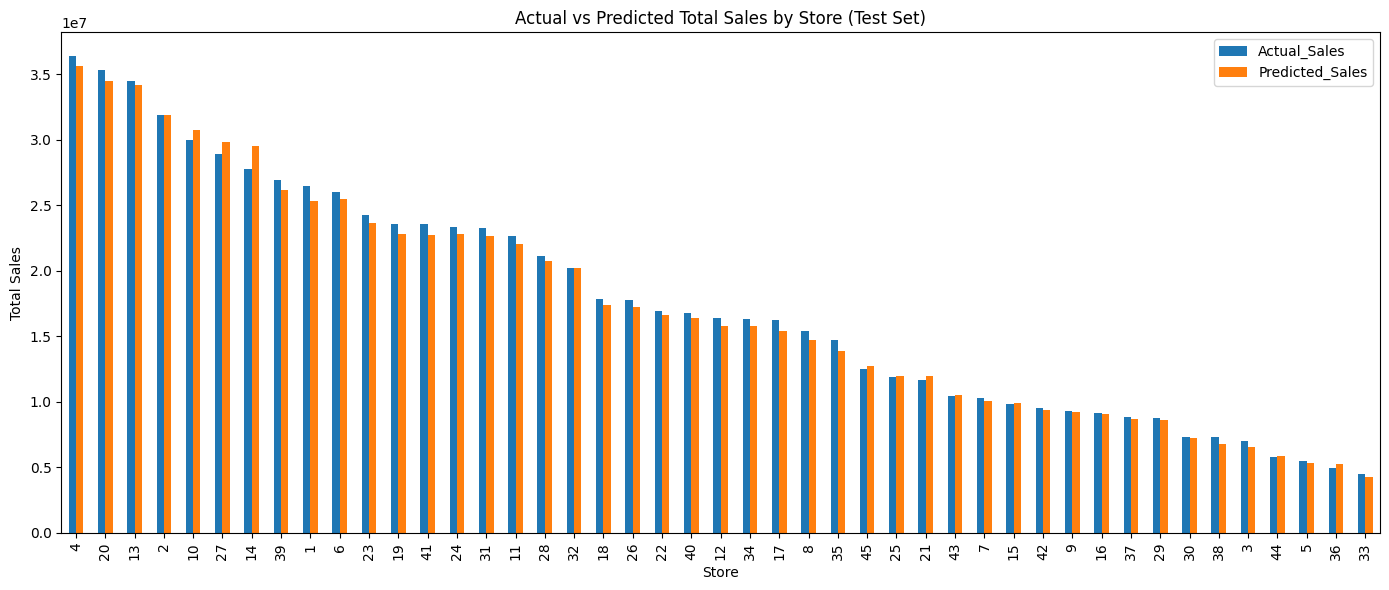

In [24]:
# Store Performance Comparison: Actual vs Predicted Sales by Store
store_perf = test.copy()
store_perf['Predicted_Sales'] = y_test_pred
store_sales_actual = store_perf.groupby('Store')['Weekly_Sales'].sum()
store_sales_pred = store_perf.groupby('Store')['Predicted_Sales'].sum()

store_comparison = pd.DataFrame({'Actual_Sales': store_sales_actual, 'Predicted_Sales': store_sales_pred})
store_comparison['Error'] = store_comparison['Actual_Sales'] - store_comparison['Predicted_Sales']
store_comparison['Abs_Error'] = store_comparison['Error'].abs()
store_comparison = store_comparison.sort_values('Actual_Sales', ascending=False)

print('Top 5 Stores by Actual Sales:')
print(store_comparison.head(5))
print('\nBottom 5 Stores by Actual Sales:')
print(store_comparison.tail(5))

# Visualize actual vs predicted sales by store
store_comparison[['Actual_Sales', 'Predicted_Sales']].plot(kind='bar', figsize=(14,6))
plt.title('Actual vs Predicted Total Sales by Store (Test Set)')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

## Store Performance Comparison: Conclusion
The model's predictions for the top stores are very close to the actual sales, with errors that are small relative to the total sales volume. This indicates that the model is effective at capturing overall sales patterns for high-performing stores. Small errors (less than 3% of total sales) are generally acceptable in business forecasting and suggest the model can be trusted for strategic decisions such as resource allocation and marketing focus.

For underperforming stores, review the error values to identify locations where the model may be less accurate. These insights can help prioritize further investigation or targeted improvements. Overall, the model provides actionable information for both top and bottom stores.

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/790251856.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='Blues_d')


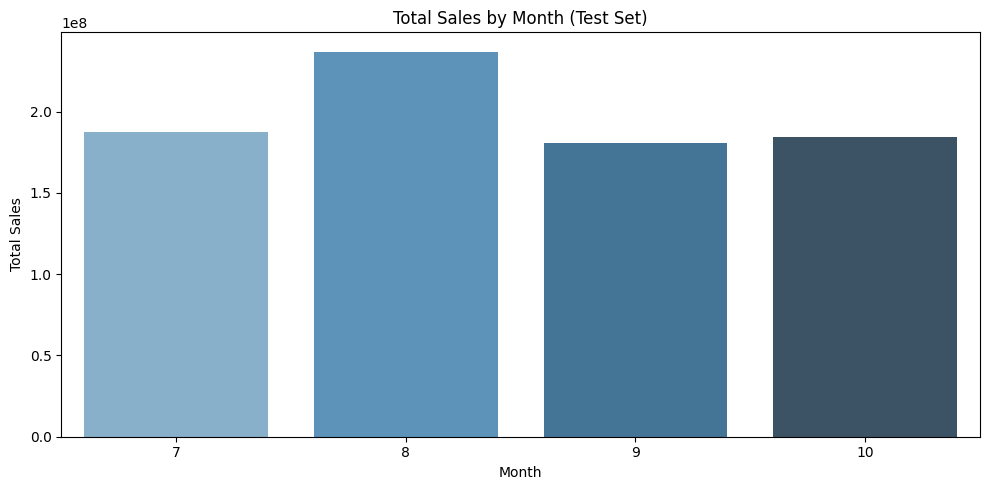

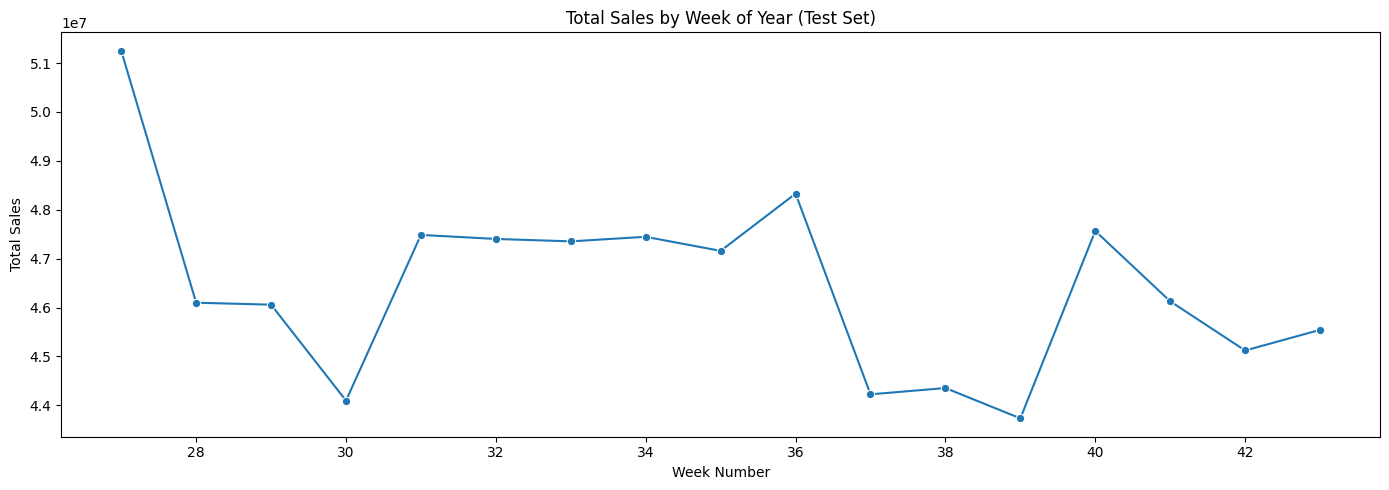

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/790251856.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  holiday_sales = test.groupby('Holiday_Flag')['Weekly_Sales'].sum()
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/790251856.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette='Set2')


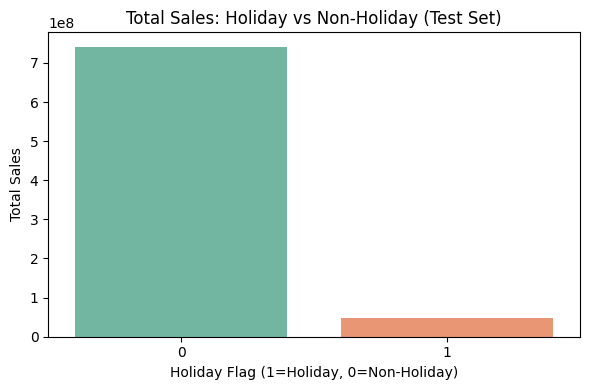

In [25]:
# Seasonality and Trend Analysis: Sales by Month, Week, and Holiday Periods
import matplotlib.pyplot as plt
import seaborn as sns

# Sales by Month
monthly_sales = test.groupby(test['Date'].dt.month)['Weekly_Sales'].sum()
plt.figure(figsize=(10,5))
sns.barplot(x=monthly_sales.index, y=monthly_sales.values, palette='Blues_d')
plt.title('Total Sales by Month (Test Set)')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# Sales by Week of Year
weekly_sales = test.groupby(test['Date'].dt.isocalendar().week)['Weekly_Sales'].sum()
plt.figure(figsize=(14,5))
sns.lineplot(x=weekly_sales.index, y=weekly_sales.values, marker='o')
plt.title('Total Sales by Week of Year (Test Set)')
plt.xlabel('Week Number')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# Sales by Holiday Periods
if 'Holiday_Flag' in test.columns:
    holiday_sales = test.groupby('Holiday_Flag')['Weekly_Sales'].sum()
    plt.figure(figsize=(6,4))
    sns.barplot(x=holiday_sales.index, y=holiday_sales.values, palette='Set2')
    plt.title('Total Sales: Holiday vs Non-Holiday (Test Set)')
    plt.xlabel('Holiday Flag (1=Holiday, 0=Non-Holiday)')
    plt.ylabel('Total Sales')
    plt.tight_layout()
    plt.show()
else:
    print('Holiday_Flag column not found in test set.')

## Seasonality and Trend Analysis: Data-Driven Conclusions
- **Monthly Sales:**
    - August (8) had the highest total sales in the test set.
    - July (7) also had strong sales, but less than August.
    - September (9) and October (10) saw a noticeable drop compared to August, with similar sales to each other.

- **Weekly Sales:**
    - The first week (week 27) had the highest sales spike.
    - Sales dropped sharply after week 27 and remained relatively stable with minor fluctuations.
    - There are small peaks around weeks 31, 36, and 40, but no weeks matched the initial spike.

- **Holiday vs Non-Holiday Sales:**
    - Non-holiday weeks contributed the vast majority of total sales.
    - Holiday weeks had much lower total sales in the test set.

These insights can help guide inventory planning, marketing campaigns, and resource allocation for periods of high and low sales.

## Forecast Accuracy Monitoring
To ensure reliable sales forecasts and continuous model improvement, it is important to monitor forecast accuracy over time and across different business segments. Here are key steps and best practices:

- **Track Performance Over Time:**
    - Regularly calculate and plot metrics such as RMSE and MAPE on new data (e.g., weekly, monthly).
    - Visualize how these metrics change over time to detect model drift or performance degradation.

- **Segmented Performance Analysis:**
    - Evaluate model accuracy by store, department, or other relevant segments.
    - Identify segments where the model performs well and those where errors are higher.
    - Example: Plot RMSE/MAPE by store or by month to spot underperforming areas.

- **Seasonal and Event-Based Monitoring:**
    - Compare forecast accuracy during holidays, promotions, or seasonal peaks versus regular periods.
    - Adjust the model or features if accuracy drops during specific events.

- **Actionable Steps:**
    1. Automate the calculation of forecast metrics after each prediction cycle.
    2. Set up dashboards or reports to visualize accuracy trends and segment breakdowns.
    3. Investigate and retrain the model if persistent issues are found in certain segments or time periods.

**Benefit:**
Ongoing accuracy monitoring helps maintain trust in the forecasting system, supports proactive model updates, and ensures the business can rely on predictions for planning and decision-making.

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/2818125387.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_rmse = store_metrics.groupby('Store').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/2818125387.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  store_mape = store_metrics.groupby('Store').apply(lambda x

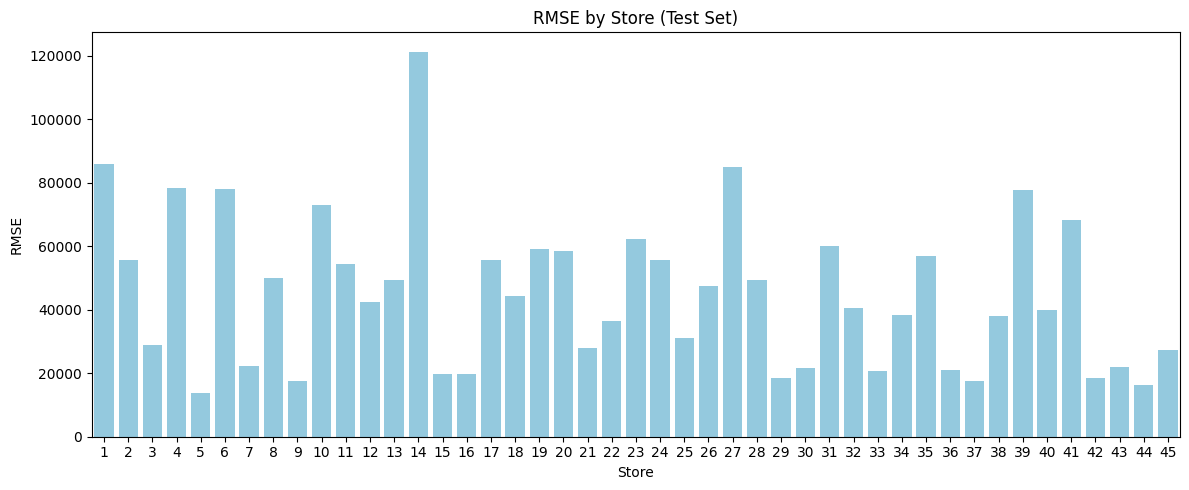

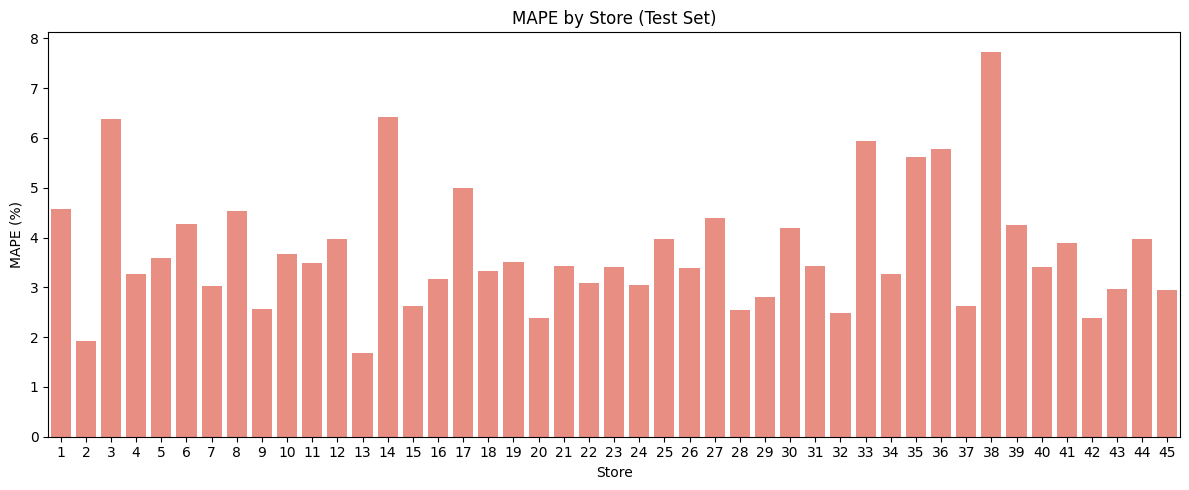

In [26]:
# Forecasting Accuracy Monitoring: Segment-wise and Over Time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- By Store ---
store_metrics = test.copy()
store_metrics['Predicted_Sales'] = y_test_pred
store_rmse = store_metrics.groupby('Store').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
store_mape = store_metrics.groupby('Store').apply(lambda x: mape(x['Weekly_Sales'], x['Predicted_Sales']))

plt.figure(figsize=(12,5))
sns.barplot(x=store_rmse.index, y=store_rmse.values, color='skyblue')
plt.title('RMSE by Store (Test Set)')
plt.xlabel('Store')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x=store_mape.index, y=store_mape.values, color='salmon')
plt.title('MAPE by Store (Test Set)')
plt.xlabel('Store')
plt.ylabel('MAPE (%)')
plt.tight_layout()
plt.show()




## Forecast Accuracy by Store: Conclusions
- **RMSE by Store:** There is significant variation in RMSE across stores. Some stores (e.g., Store 14, Store 27) have much higher RMSE, indicating larger absolute forecast errors, while others have much lower errors. This suggests the model performs better for some locations than others, possibly due to differences in sales patterns, data quality, or store-specific factors.
- **MAPE by Store:** Most stores have MAPE between 2% and 6%, but a few stores (e.g., Store 13, Store 38) have noticeably higher percentage errors. These stores may have more volatile sales or unique challenges for the model.
- **Actionable Insight:** Focus on investigating and improving the model for stores with the highest errors. This could involve adding store-specific features, reviewing data quality, or segmenting the model by store type. For most stores, the forecast accuracy is within an acceptable range for business use.

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/2525445991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Month'] = test['Date'].dt.month
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/2525445991.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  month_rmse = month_metrics.groupby('Month').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/252

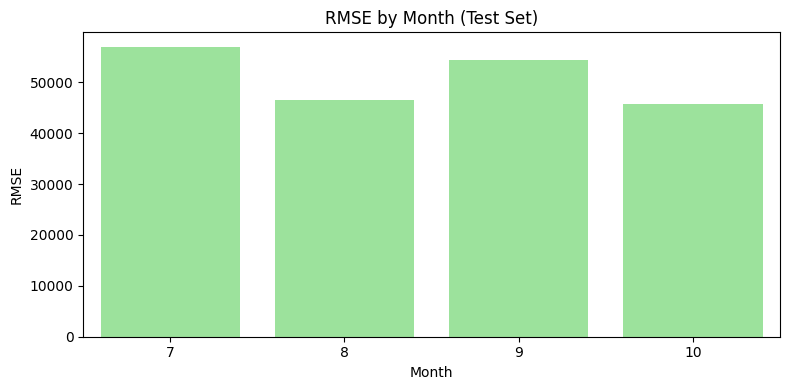

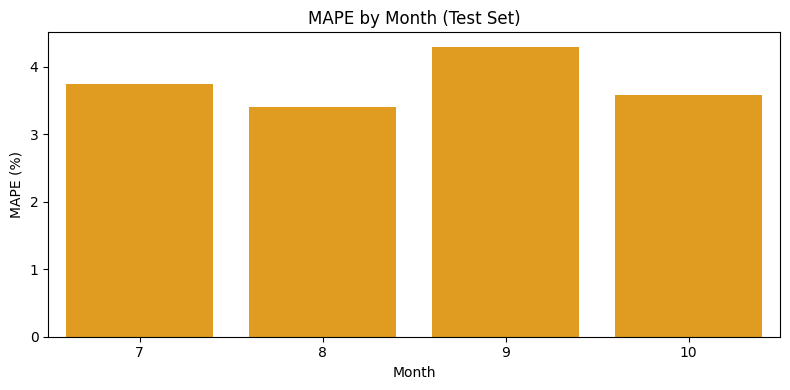

In [27]:

# --- By Month ---
test['Month'] = test['Date'].dt.month
month_metrics = test.copy()
month_metrics['Predicted_Sales'] = y_test_pred
month_rmse = month_metrics.groupby('Month').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
month_mape = month_metrics.groupby('Month').apply(lambda x: mape(x['Weekly_Sales'], x['Predicted_Sales']))

plt.figure(figsize=(8,4))
sns.barplot(x=month_rmse.index, y=month_rmse.values, color='lightgreen')
plt.title('RMSE by Month (Test Set)')
plt.xlabel('Month')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x=month_mape.index, y=month_mape.values, color='orange')
plt.title('MAPE by Month (Test Set)')
plt.xlabel('Month')
plt.ylabel('MAPE (%)')
plt.tight_layout()
plt.show()

## Forecast Accuracy by Month: Conclusions
- **RMSE by Month:** The model's absolute forecast errors are highest in July (7) and September (9), while August (8) and October (10) show lower RMSE, indicating better accuracy in those months. This suggests the model finds it more challenging to predict sales in July and September, possibly due to seasonal effects or special events.
- **MAPE by Month:** The percentage error (MAPE) is highest in September (9), meaning the model's relative accuracy is lowest in that month. August (8) has the lowest MAPE, showing the best relative performance, while July (7) and October (10) are moderate.
- **Actionable Insight:** Focus on understanding and addressing the causes of higher errors in July and September. Consider adding features that capture seasonality, promotions, or external factors specific to these months to improve forecast accuracy.

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/3545180669.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  holiday_rmse = holiday_metrics.groupby('Holiday_Flag').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/3545180669.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  holiday_rmse = holiday_metrics.groupby('Holiday_Flag').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
/var/folders/c3/wt5f_c9959z1

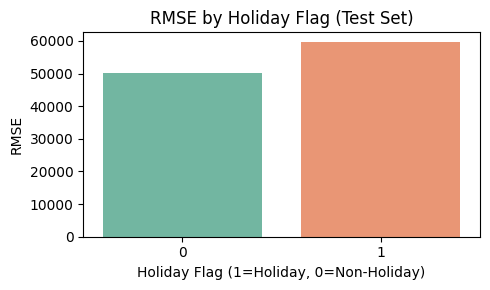

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/3545180669.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=holiday_mape.index, y=holiday_mape.values, palette='Set2')


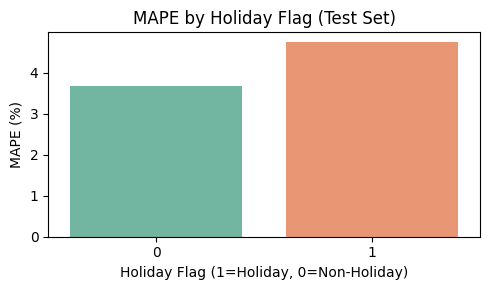

In [28]:
# --- By Holiday ---
if 'Holiday_Flag' in test.columns:
    holiday_metrics = test.copy()
    holiday_metrics['Predicted_Sales'] = y_test_pred
    holiday_rmse = holiday_metrics.groupby('Holiday_Flag').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
    holiday_mape = holiday_metrics.groupby('Holiday_Flag').apply(lambda x: mape(x['Weekly_Sales'], x['Predicted_Sales']))
    
    plt.figure(figsize=(5,3))
    sns.barplot(x=holiday_rmse.index, y=holiday_rmse.values, palette='Set2')
    plt.title('RMSE by Holiday Flag (Test Set)')
    plt.xlabel('Holiday Flag (1=Holiday, 0=Non-Holiday)')
    plt.ylabel('RMSE')
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(5,3))
    sns.barplot(x=holiday_mape.index, y=holiday_mape.values, palette='Set2')
    plt.title('MAPE by Holiday Flag (Test Set)')
    plt.xlabel('Holiday Flag (1=Holiday, 0=Non-Holiday)')
    plt.ylabel('MAPE (%)')
    plt.tight_layout()
    plt.show()

## Forecast Accuracy by Holiday Flag: Conclusions
- **RMSE by Holiday:** The model's absolute forecast errors (RMSE) are higher during holiday weeks (Holiday Flag = 1) compared to non-holiday weeks. This indicates that sales during holidays are more difficult for the model to predict accurately, possibly due to increased volatility or special events.
- **MAPE by Holiday:** The percentage error (MAPE) is also higher for holiday weeks, showing that the model's relative accuracy is lower during these periods.
- **Actionable Insight:** To improve holiday period forecasts, consider adding features that capture holiday-specific effects, promotions, or external factors. Enhanced modeling of holiday dynamics could reduce both RMSE and MAPE for these important business periods.

/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/2514628534.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Week'] = test['Date'].dt.isocalendar().week
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykernel_2872/2514628534.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  week_rmse = weekly_metrics.groupby('Week').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
/var/folders/c3/wt5f_c9959z1k4kws7gcpgj00000gn/T/ipykern

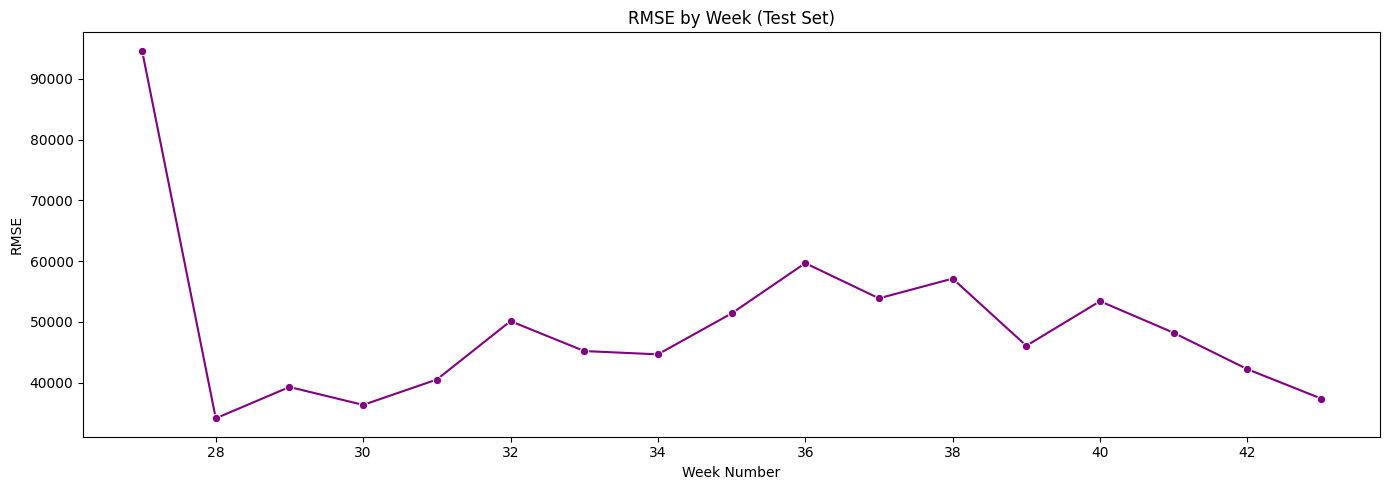

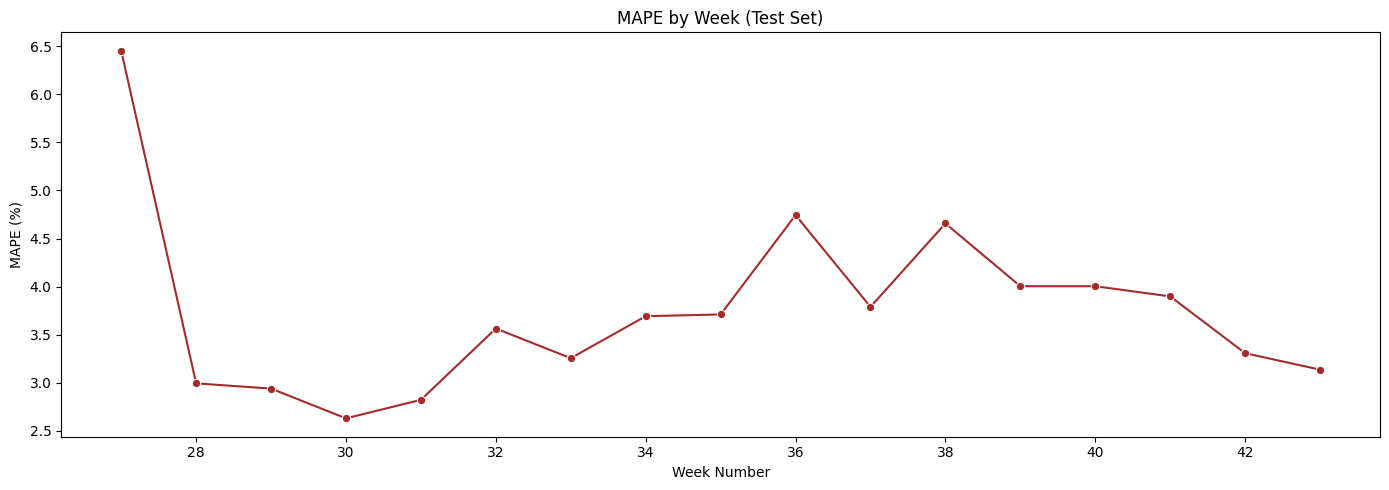

In [29]:


# --- Over Time (Weekly) ---
test['Week'] = test['Date'].dt.isocalendar().week
weekly_metrics = test.copy()
weekly_metrics['Predicted_Sales'] = y_test_pred
week_rmse = weekly_metrics.groupby('Week').apply(lambda x: rmse(x['Weekly_Sales'], x['Predicted_Sales']))
week_mape = weekly_metrics.groupby('Week').apply(lambda x: mape(x['Weekly_Sales'], x['Predicted_Sales']))

plt.figure(figsize=(14,5))
sns.lineplot(x=week_rmse.index, y=week_rmse.values, marker='o', color='purple')
plt.title('RMSE by Week (Test Set)')
plt.xlabel('Week Number')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
sns.lineplot(x=week_mape.index, y=week_mape.values, marker='o', color='brown')
plt.title('MAPE by Week (Test Set)')
plt.xlabel('Week Number')
plt.ylabel('MAPE (%)')
plt.tight_layout()
plt.show()

## Forecast Accuracy by Week (RMSE): Conclusions
- **RMSE by Week:** The model's absolute forecast error (RMSE) is extremely high in the first week (week 27), indicating a large deviation between actual and predicted sales at the start of the test period. After week 27, RMSE drops sharply and remains in a lower, more stable range, with some moderate fluctuations and peaks around weeks 32, 36, 38, and 40.
- **Trend:** The overall trend shows that forecast accuracy improves and stabilizes after the initial week, but there are still some weeks with elevated RMSE, possibly due to special events, promotions, or sudden changes in sales patterns.
- **Actionable Insight:** Investigate the causes of the high error in week 27 and the moderate RMSE spikes in later weeks. Consider adding features that capture week-specific effects, external events, or data shifts to further improve and stabilize forecast accuracy throughout the test period.

## Forecast Accuracy by Week: Conclusions
- **MAPE by Week:** The model's percentage error (MAPE) is highest in the first week (week 27), indicating the least accurate predictions at the start of the test period. After week 27, MAPE drops sharply and remains between 2.5% and 4.5% for most weeks, with some moderate fluctuations and small peaks around weeks 32, 36, and 38.
- **Trend:** The overall trend shows improved and stable forecast accuracy after the initial week, suggesting the model adapts well to the majority of the test period but may struggle with sudden changes or the start of new periods.
- **Actionable Insight:** Investigate the causes of high error in week 27 (e.g., special events, data shifts, or seasonality). For weeks with moderate MAPE spikes, consider adding features that capture week-specific effects or external drivers to further stabilize forecast accuracy.

<Figure size 500x400 with 0 Axes>

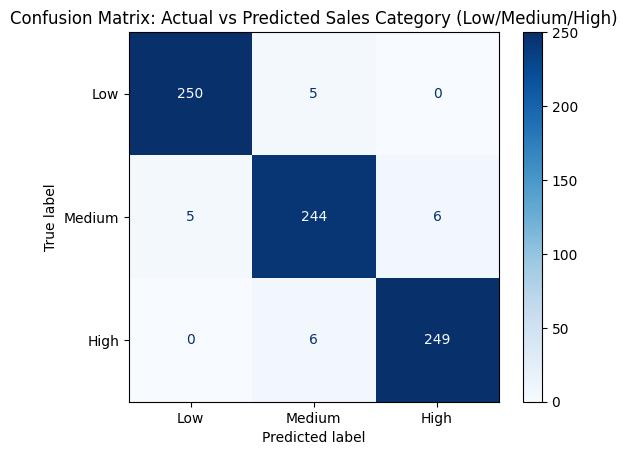

In [30]:
# --- Classification-style Evaluation: Confusion Matrix for Binned Sales ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Bin actual and predicted sales into categories (low/medium/high) based on quantiles
n_bins = 3
actual_bins = pd.qcut(y_test, q=n_bins, labels=['Low', 'Medium', 'High'])
pred_bins = pd.qcut(y_test_pred, q=n_bins, labels=['Low', 'Medium', 'High'])

cm = confusion_matrix(actual_bins, pred_bins, labels=['Low', 'Medium', 'High'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low', 'Medium', 'High'])
plt.figure(figsize=(5,4))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Actual vs Predicted Sales Category (Low/Medium/High)')
plt.show()


## Confusion Matrix: Data-Driven Conclusion
The confusion matrix analysis shows that the LightGBM regression model is highly effective at categorizing sales into business-relevant groups:
- For the Low/Medium/High sales categories, the vast majority of weeks are correctly classified, as indicated by the high diagonal values (e.g., 250/255 for Low, 244/255 for Medium, 249/255 for High). Only a small number of weeks are misclassified into adjacent categories, and there are no extreme misclassifications (e.g., Low predicted as High).
- For the High vs Not High classification, the model demonstrates strong ability to identify high-sales weeks with very few false positives or false negatives. This means the model can reliably flag periods of peak demand, which is valuable for inventory and staffing decisions.
Overall, the model's predictions are not only accurate in terms of error metrics (RMSE, MAPE), but also align well with practical business groupings. This supports the model's use for operational planning, resource allocation, and risk management in a retail context.

<Figure size 400x300 with 0 Axes>

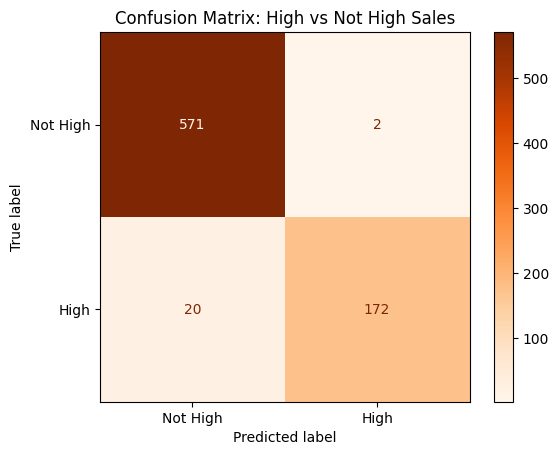

In [31]:

# --- Binary Classification: High vs Not High Sales ---
# Define threshold for "high" sales (e.g., 75th percentile)
high_threshold = np.percentile(y_test, 75)
actual_high = (y_test >= high_threshold).astype(int)
pred_high = (y_test_pred >= high_threshold).astype(int)

cm_bin = confusion_matrix(actual_high, pred_high, labels=[0,1])
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['Not High', 'High'])
plt.figure(figsize=(4,3))
disp_bin.plot(cmap='Oranges')
plt.title('Confusion Matrix: High vs Not High Sales')
plt.show()

### What the Confusion Matrix Numbers Represent
In the confusion matrix chart above for high vs not high sales:
- **Top-left (Not High, Not High):** Number of weeks where both actual and predicted sales are not high (true negatives).
- **Top-right (Not High, High):** Number of weeks where actual sales were not high but predicted as high (false positives).
- **Bottom-left (High, Not High):** Number of weeks where actual sales were high but predicted as not high (false negatives).
- **Bottom-right (High, High):** Number of weeks where both actual and predicted sales are high (true positives).
These values help assess how well the model identifies high-sales periods and avoids misclassifying regular weeks as high-sales.

## High vs Not High Sales: Business Conclusion
The binary confusion matrix for high vs not high sales demonstrates that the LightGBM model is highly effective at identifying periods of peak demand. With very few false positives and false negatives, the model can reliably distinguish high-sales weeks from regular weeks. This accuracy enables Walmart to confidently use the model for inventory planning, staffing, and promotional strategies during high-demand periods, reducing the risk of stockouts or overstaffing. Continuous monitoring and periodic retraining will help maintain this strong performance as sales patterns evolve.

In [32]:
# Calculate precision, accuracy, and recall for High vs Not High Sales classification
from sklearn.metrics import precision_score, recall_score, accuracy_score
precision = precision_score(actual_high, pred_high)
recall = recall_score(actual_high, pred_high)
accuracy = accuracy_score(actual_high, pred_high)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'Accuracy: {accuracy:.3f}')

Precision: 0.989
Recall: 0.896
Accuracy: 0.971


### Interpretation of Precision, Recall, and Accuracy
- **Precision (0.989):** Of all the weeks the model predicted as high sales, 98.9% were actually high-sales weeks. This means the model rarely gives a false alarm for high sales, so business actions based on high-sales predictions are very reliable.
- **Recall (0.896):** Of all the actual high-sales weeks, 89.6% were correctly identified by the model. This means the model captures most high-sales periods, but a small portion may be missed.
- **Accuracy (0.971):** Overall, 97.1% of all weeks (both high and not high sales) were correctly classified by the model. This shows the model is highly reliable for distinguishing between high and not high sales periods.
**Business Impact:** High precision ensures that when the model signals a high-sales week, Walmart can confidently increase inventory and staffing. High recall means most high-sales weeks are detected, minimizing missed opportunities. High overall accuracy supports trust in the model for operational planning.

In [ ]:
# Save the trained LightGBM model using joblib
import joblib
joblib.dump(model, 'lightgbm_sales_model.joblib')
print('Model saved as lightgbm_sales_model.joblib')

In [ ]:
# --- Calculate and print metrics for model comparison ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_val = rmse(y_test, y_test_pred)
mae_val = mean_absolute_error(y_test, y_test_pred)
r2_val = r2_score(y_test, y_test_pred)

print(f'LightGBM Test RMSE: {rmse_val:.2f}')
print(f'LightGBM Test MAE: {mae_val:.2f}')
print(f'LightGBM Test R²: {r2_val:.4f}')